# Quantum Support Vector Machine

In this notebook we will implement a quantum support vector machine (QSVM) algorithm. The QSVM is a quantum algorithm that can be used to classify data. It is based on the classical support vector machine (SVM) algorithm, but it uses a quantum kernel to perform the calculations.
Input data is encoded into quantum states, and the quantum kernel is used to calculate the inner product of the input data. The result of the quantum kernel is then used to train a classical SVM.

## Dataset

In this notebook we will use the algorithm to classify data from the `ds_haar_obs` dataset.
The dataset contains 10,000 examples consisting of 10 features and a binary label: _sep_.
**Undersampling** is used to reduce the dataset size since kernel based methods have cubic complexity in the number of samples.
The dataset is balanced.

## Quantum Kernel

The kernel is calculated as the square of the absolute value of the braket product of the encoded input states.
The features are encoded into quantum states with a Pauli feature map.

## Features Reduction

The advantage of kernel based methods is the computational efficiency when dealing with high dimensional data.
Due to how the feature are obtained from the original quantum states (the probability of successfully projecting onto a singlet Bell state, given a particular pair of local projections), we thought that a feature reduction to be usefull.
As such the model is trained and tested with different number of features, removing less important ones at each step using LASSO.

In [10]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from qiskit.circuit.library import PauliFeatureMap
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit_algorithms.state_fidelities import ComputeUncompute, BaseStateFidelity
from qiskit_machine_learning.kernels import FidelityQuantumKernel

from typing import Optional, Tuple
import time

# Dataset

In [11]:
# load dataset
df = pd.read_csv('../datasets/ds_haar_obs.csv')
df.head()

,P11,P22,P33,P44,P13,P14,P24,P12,P23,P34,sep
0,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,0.363562,True
1,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,0.478920,True
2,0.176573,0.067155,0.055469,0.062003,0.256511,0.179351,0.105687,0.311796,0.154631,0.023350,False
3,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,0.022839,True
4,0.139089,0.347255,0.249997,0.201476,0.491367,0.382842,0.488343,0.233877,0.272572,0.224575,False


## Distribution of the features

All features are fairly uniformly distributed between 0 and 0.5.
As such **no scaling** is performed.

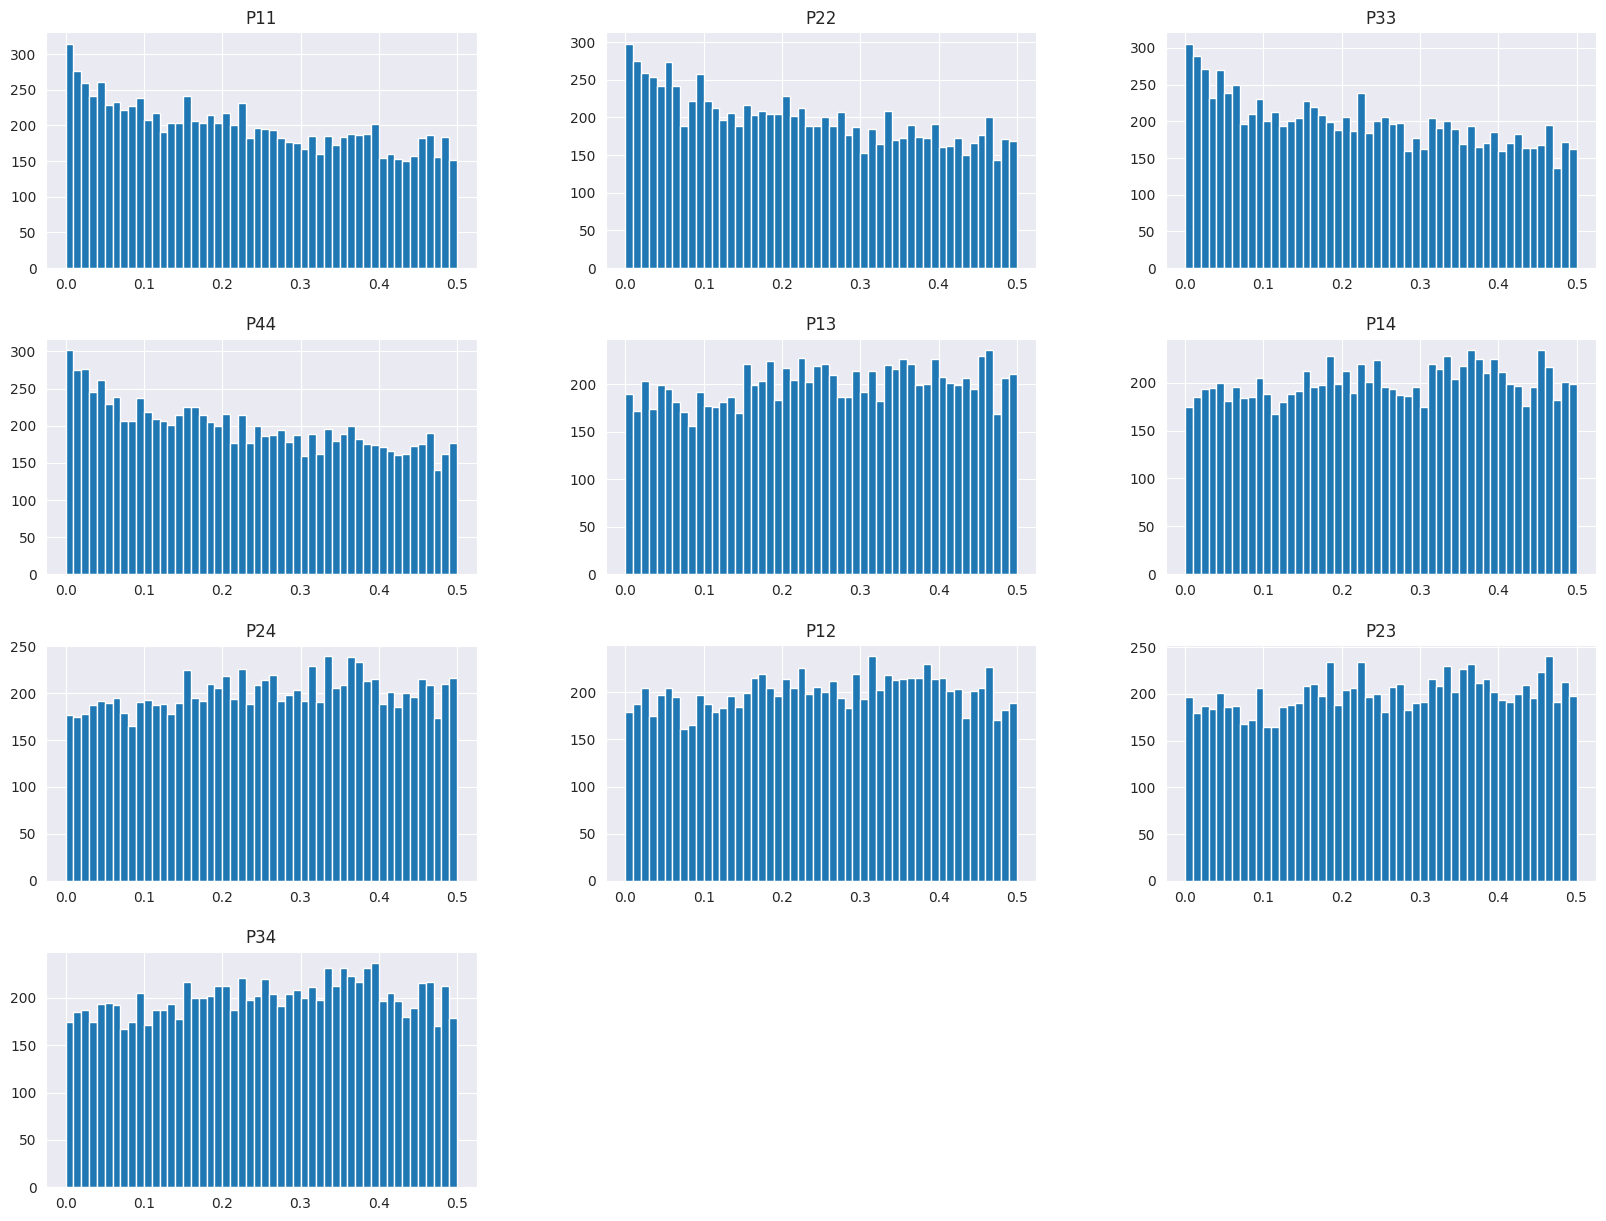

In [12]:
# split data
X = df.drop('sep', axis=1)
y = df['sep']

# X value distribution
X.hist(bins=50, figsize=(20,15))
plt.show()

## Undersampling

The dataset is undersampled to reduce the number of samples to 200.
We use a random undersampler to keep the dataset balanced.

In [13]:
# undersampling 
sampling_strategy = {0: 100, 1: 100}
undersample = RandomUnderSampler(sampling_strategy = sampling_strategy)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# print counts
print(f"sep/ent value counts: {y_resampled.value_counts()}")

sep/ent value counts: sep
False    100
True     100
Name: count, dtype: int64


## Train and Test Split

In [14]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 160
Test size: 40


# QSVM model

In this section we write the functions that train and test the _QSVM_ model, scalable with the number of features.

The conceptual steps are:
1. **Feature mapping**: the input data is mapped to a quantum state using a feature map.
2. **Kernel matrix computation**: the quantum state is used to compute the kernel matrix.
3. **Training**: the kernel matrix is used to train a classical SVM model.
4. **Prediction**: the trained model is used to predict the test data.

## Feature map

Note that, dipending on the feature map and the number of features, the quantum circuit can become very large and complex, probably not suitable for real quantum hardware.
Check the [reference](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliFeatureMap) for impolementation details.

In [15]:
from qsvm import get_feature_map

help(get_feature_map)

Help on function get_feature_map in module qsvm:

get_feature_map(n_features: int, paulis: list[str] = None, reps: int = 2, entanglement: str = 'linear') -> qiskit.circuit.quantumcircuit.QuantumCircuit
    Wrapper to return a feature map quantum circuit.
    
    The function returns a quantum circuit that maps the input data to a quantum state.
    By default, the feature map is a [Z, ZZ] PauliFeatureMap with linear entanglement.
    
    Args:
        n_features (int): feature dimension.
        paulis (list[str]): list of Pauli gates to use in the feature map.
        reps (int): number of repetitions of the feature map.
        entanglement (str): entanglement strategy for the feature map.
    
    Returns:
        QuantumCircuit: the feature map quantum circuit.


## Kernel function

Multiple kernel functions are implemented.

- `manual_quantum_kernel` is implemented using _qiskit_ for encoding the input data and 'numpy' to compute the product.
- `qiskit_quantum_kernel` uses _qiskit_ for both encoding and computing the product.

The numpy version is more efficient and equivalent to the qiskit version when default parameters are used.

- `sampler_quantum_kernel` uses _qiskit_ and a sampler to compute the kernel product, given as the probability of measuring `|00>`

The last one has not yielded good results, as such is not used.

In [16]:
from qsvm import manual_quantum_kernel, qiskit_quantum_kernel, sampler_quantum_kernel

# test the kernel functions
x1 = [0.1, 0.2, 0.3, 0.4]
x2 = [0.2, 0.3, 0.4, 0.5]

print(f"Manual kernel: {manual_quantum_kernel(x1, x2)}")
print(f"Qiskit kernel: {qiskit_quantum_kernel(x1, x2)}")
print(f"Sampler kernel: {sampler_quantum_kernel(x1, x2)}")

Manual kernel: 0.09356147231245268
Qiskit kernel: 0.0935614723124527
Sampler kernel: 0.251953125


# Training and Testing


In this section we train models with the different kernels and show the accuracy of the model on the test set.
The training consists of calculating the kernel matrix and then training a classical SVM model.

In [17]:
from qsvm import train_test

help(train_test)

Help on function train_test in module qsvm:

train_test(X_train: pandas.core.frame.DataFrame, y_train: pandas.core.series.Series, X_test: pandas.core.frame.DataFrame, y_test: pandas.core.series.Series, feature_map: Optional[qiskit.circuit.library.data_preparation.pauli_feature_map.PauliFeatureMap] = None, kernel_function: Optional[str] = 'manual', sampler: Optional[qiskit.primitives.sampler.Sampler] = None, fidelity: Optional[qiskit_algorithms.state_fidelities.base_state_fidelity.BaseStateFidelity] = None) -> Tuple[sklearn.svm._classes.SVC, float]
    Wrapper to train the QSVM model and test it on unseen data.
    
    The function trains the QSVM model using the input training data and then tests it on the input test data.
    The function returns the trained model and the test score (accuracy).
    
    Args:
        X_train: Input training data.
        y_train: Labels for the training data.
        X_test: Test data.
        y_test: Labels for the test data.
        feature_map: fe

### Manual kernel

In [10]:
start = time.time()
model, score = train_test(X_train, y_train, X_test, y_test)
end = time.time()

print(f"Accuracy: {score}, time: {end - start}")

Accuracy: 0.925, time: 306.225204706192


### Qiskit kernel

In [11]:
start = time.time()
model, score = train_test(X_train, y_train, X_test, y_test, kernel_function="qiskit")
end = time.time()

print(f"Accuracy: {score}, time: {end - start}")

Accuracy: 0.925, time: 758.2914803028107


### Sampler kernel

In [9]:
start = time.time()
model, score = train_test(X_train, y_train, X_test, y_test, kernel_function="sampler")
end = time.time()

print(f"Accuracy: {score}, time: {end - start}")

Accuracy: 0.625, time: 768.2642657756805


## Feature Reduction

In [10]:
times = []
accuracy = []
features = [10, 9, 8, 7, 6, 5, 4, 3, 2]
models = []

while len(X_train.columns) > 1:
    # train and test the model
    start = time.time()
    model, score = train_test(X_train, y_train, X_test, y_test)
    end = time.time()
    times.append(end - start)
    accuracy.append(score)
    models.append(model)
    print(f"Features: {len(X_train.columns)}, Accuracy: {score}, Time: {end - start}")
    
    # perform the feature reduction
    # Train a Logistic Regression model with L1 regularization
    lr_model = LogisticRegression(penalty='l1', solver='liblinear')
    lr_model.fit(X_train, y_train)
    
    # Extract coefficients assigned to each feature
    lr_coefficients = pd.Series(lr_model.coef_[0], index=X_train.columns)
    
    # Sort coefficients in descending order
    lr_coefficients_sorted = lr_coefficients.abs().sort_values(ascending=False)
    
    print(f"Removing feature: {lr_coefficients_sorted.index[-1]}")
    X_train = X_train.drop(lr_coefficients_sorted.index[-1], axis=1)
    X_test = X_test.drop(lr_coefficients_sorted.index[-1], axis=1)

Features: 10, Accuracy: 0.975, Time: 320.58085322380066
Removing feature: P12
Features: 9, Accuracy: 0.95, Time: 280.426545381546
Removing feature: P24
Features: 8, Accuracy: 0.95, Time: 239.71457767486572
Removing feature: P14
Features: 7, Accuracy: 0.925, Time: 201.82148122787476
Removing feature: P13
Features: 6, Accuracy: 0.875, Time: 172.51015448570251
Removing feature: P44
Features: 5, Accuracy: 0.85, Time: 148.38388442993164
Removing feature: P33
Features: 4, Accuracy: 0.8, Time: 122.77498936653137
Removing feature: P22
Features: 3, Accuracy: 0.7, Time: 89.28555727005005
Removing feature: P23
Features: 2, Accuracy: 0.575, Time: 60.38946890830994
Removing feature: P34


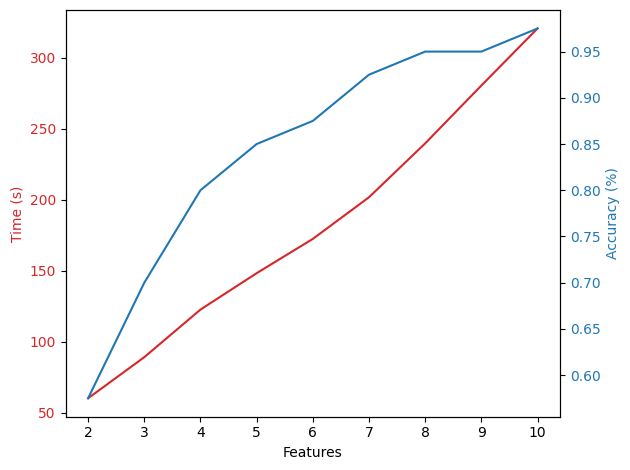

In [11]:
from qsvm import plot_results

plot_results(features, times, accuracy)

# Code for generating plots

In [18]:
predictions = []

# train the models and append the predicted values
while len(X_train.columns) > 1:
    print(f"Features: {len(X_train.columns)}")
    
    # train and test the model
    # compute the kernel matrix
    n = len(X_train)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            K[i, j] = manual_quantum_kernel(X_train.iloc[i], X_train.iloc[j])
            K[j, i] = K[i, j]  # the kernel matrix is symmetric
    
    # train the SVM model
    model = svm.SVC(kernel='precomputed', probability=True)
    model.fit(K, y_train)
    
    # compute the kernel matrix for the test data
    n = len(X_test)
    m = len(X_train)
    K = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            K[i, j] = manual_quantum_kernel(X_train.iloc[j], X_test.iloc[i])
    
    # predict the test data
    prediction = model.predict_proba(K)
    predictions.append(prediction)
    
    # perform the feature reduction
    # Train a Logistic Regression model with L1 regularization
    lr_model = LogisticRegression(penalty='l1', solver='liblinear')
    lr_model.fit(X_train, y_train)
    
    # Extract coefficients assigned to each feature
    lr_coefficients = pd.Series(lr_model.coef_[0], index=X_train.columns)
    
    # Sort coefficients in descending order
    lr_coefficients_sorted = lr_coefficients.abs().sort_values(ascending=False)
    
    print(f"Removing feature: {lr_coefficients_sorted.index[-1]}")
    X_train = X_train.drop(lr_coefficients_sorted.index[-1], axis=1)
    X_test = X_test.drop(lr_coefficients_sorted.index[-1], axis=1)

Features: 10
Removing feature: P23
Features: 9
Removing feature: P24
Features: 8
Removing feature: P14
Features: 7
Removing feature: P13
Features: 6
Removing feature: P33
Features: 5
Removing feature: P22
Features: 4
Removing feature: P11
Features: 3
Removing feature: P12
Features: 2
Removing feature: P34


In [21]:
print(f"shape of predictions: {len(predictions)}")
predi

shape of predictions: 9


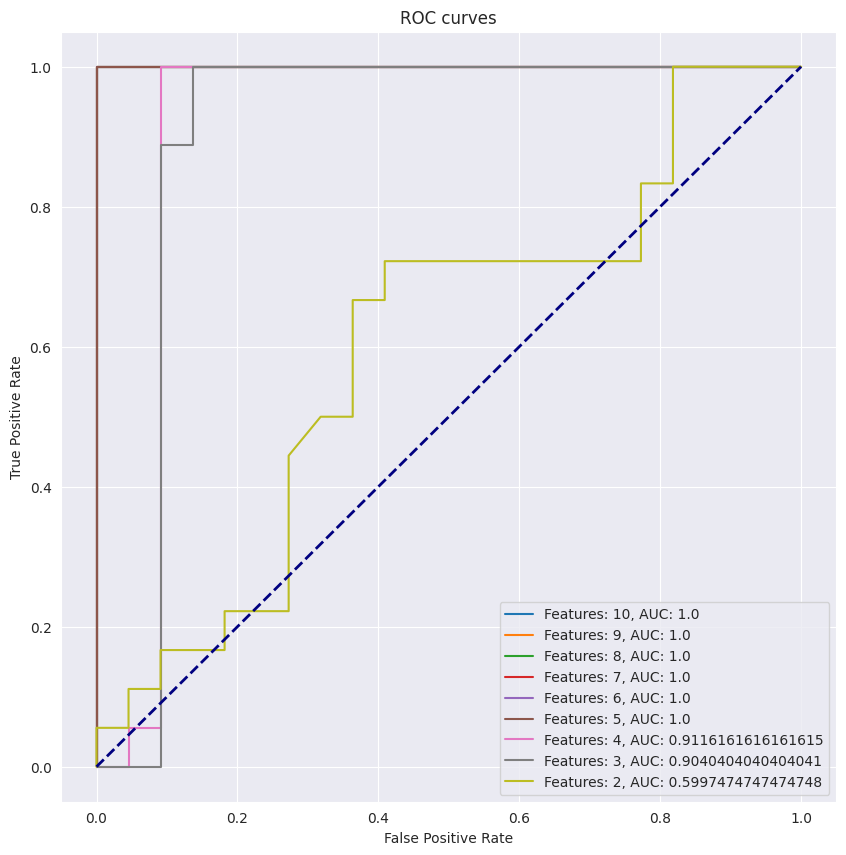

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

features = [10, 9, 8, 7, 6, 5, 4, 3, 2]
fprs, tprs, aucs = [], [], []
for prediction in predictions:
    probas = prediction[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, probas)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))

plt.figure(figsize=(10, 10))
for i in range(len(fprs)):
    plt.plot(fprs[i], tprs[i], label=f"Features: {features[i]}, AUC: {aucs[i]}")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend()
plt.show()

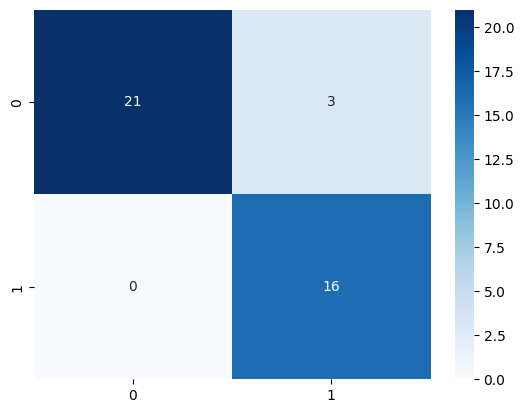

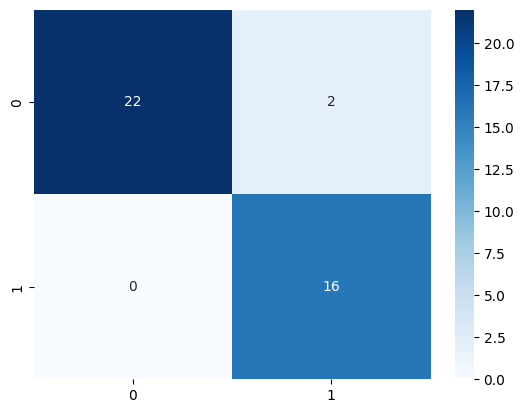

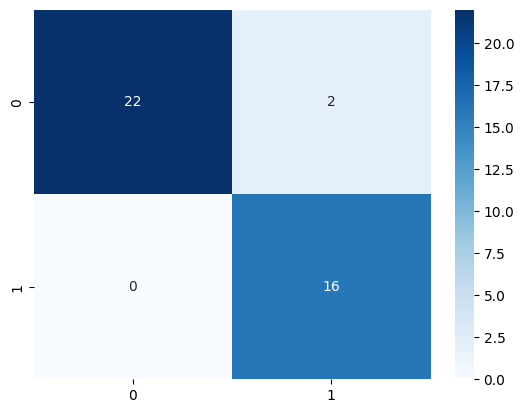

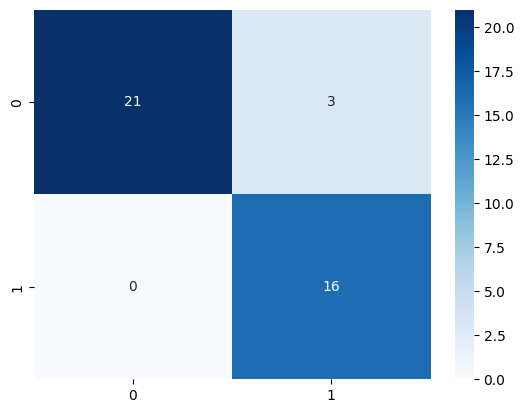

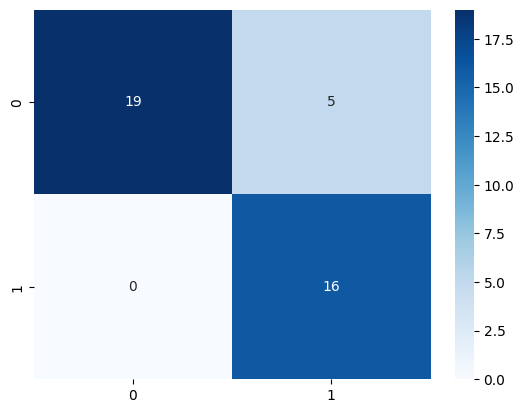

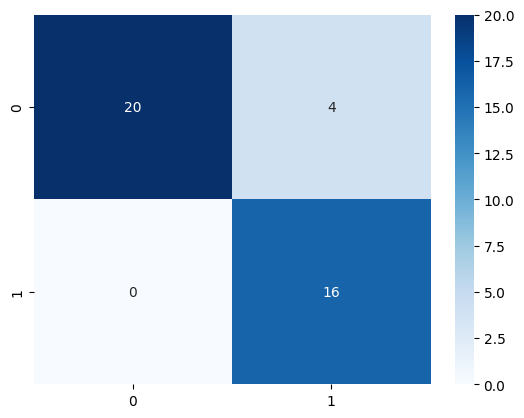

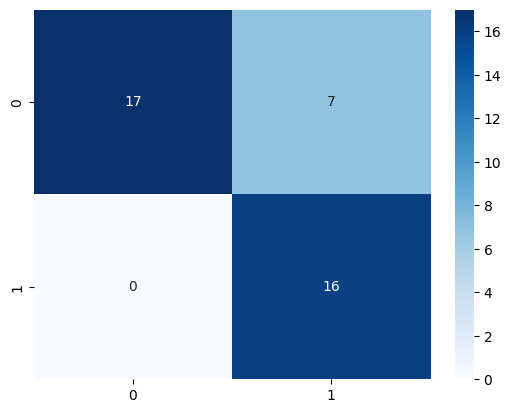

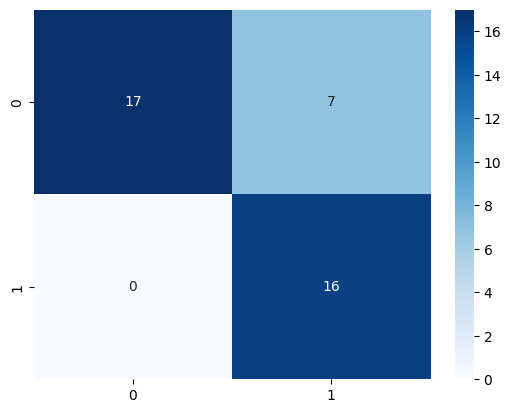

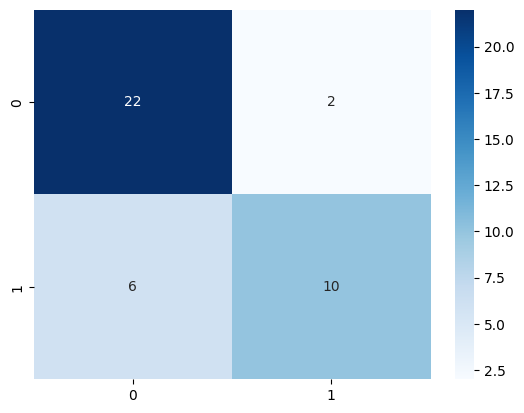

In [37]:
# plot confusion matrices
from sklearn.metrics import confusion_matrix
import seaborn as sns

for prediction in predictions:
    cm = confusion_matrix(y_test, prediction)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.show()